In [1]:
# Initial setup (for Jupyter notebooks)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

# For nicer plots
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np

import git
import os

# Path to the root of the git repository
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print(f'Path to git repo: {path_global}')

Path to git repo: /home/matias/Documents/PhD/code


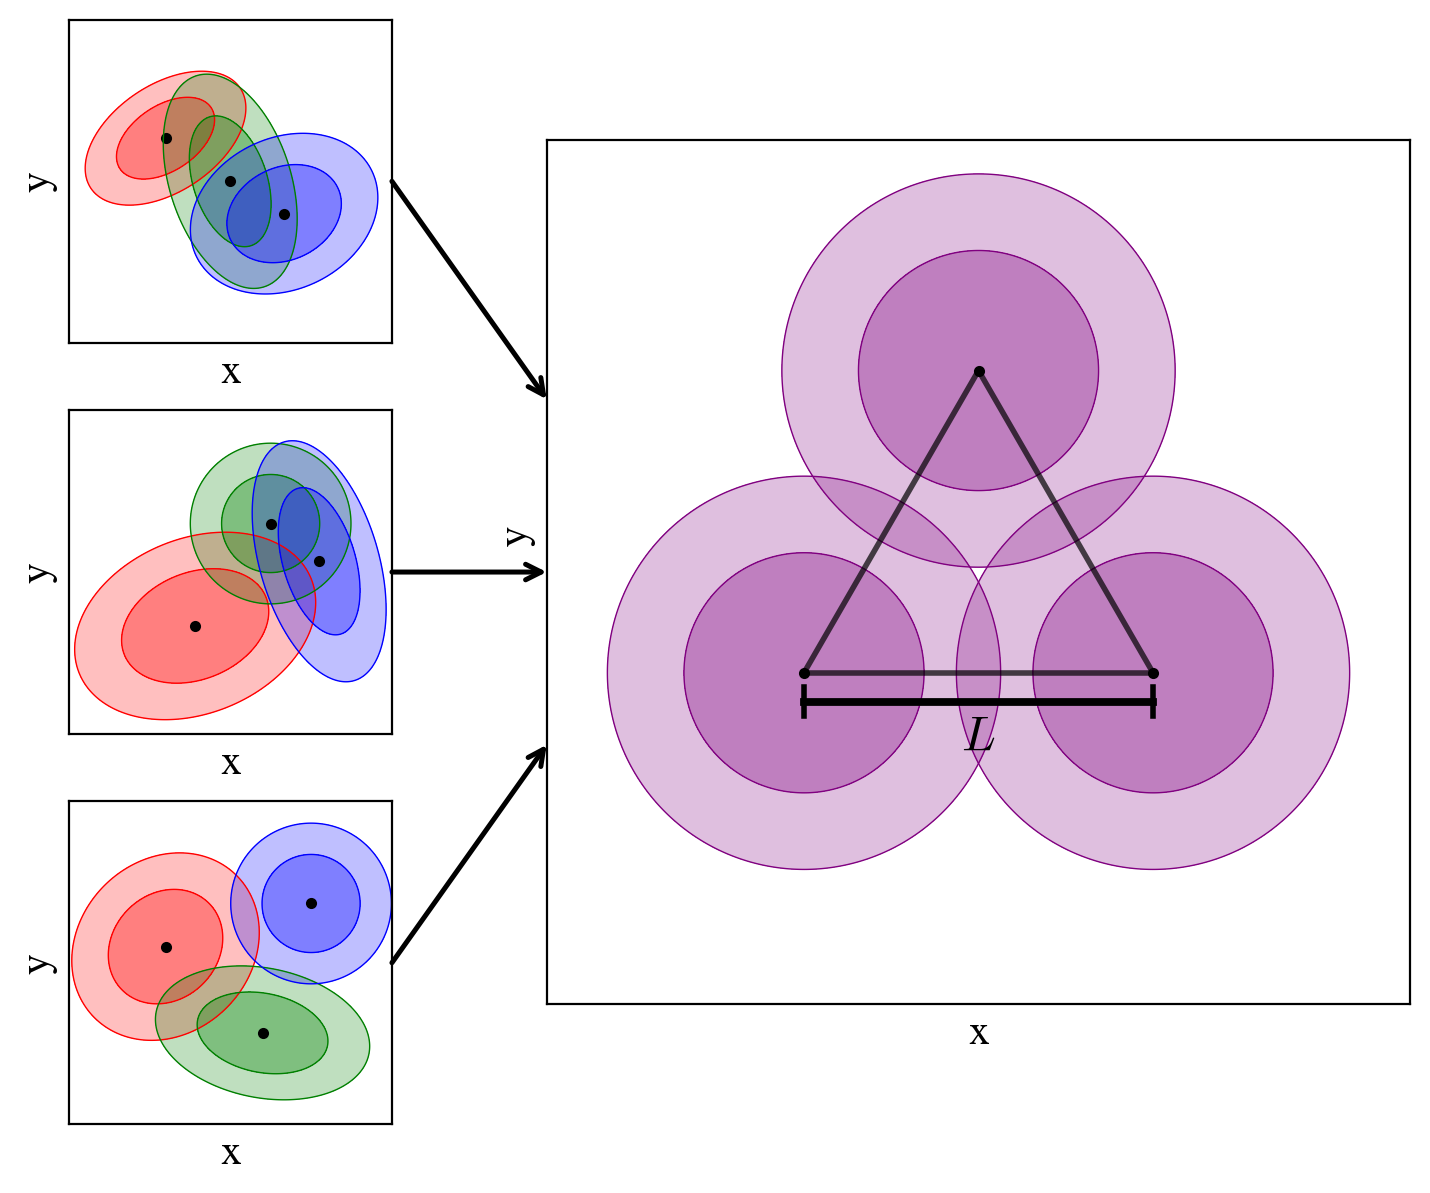

In [2]:
# -------------------------------
# Utility functions
# -------------------------------
def gaussian_2d_pdf(X, Y, mean, cov):
    """
    Evaluate the 2D Gaussian probability density on a grid (X, Y).

    Parameters
    ----------
    X, Y : ndarray
        2D arrays defining the grid points.
    mean : array_like, shape (2,)
        Mean of the Gaussian distribution.
    cov : array_like, shape (2, 2)
        Covariance matrix of the Gaussian distribution.

    Returns
    -------
    Z : ndarray
        2D array with the Gaussian density evaluated at each (x, y) point.
    """
    mu = np.asarray(mean).reshape(2, 1)
    Sigma = np.asarray(cov)
    inv = np.linalg.inv(Sigma)
    det = np.linalg.det(Sigma)
    XY = np.vstack([X.ravel(), Y.ravel()])
    d2 = np.sum((XY - mu).T @ inv * (XY - mu).T, axis=1)  # Mahalanobis^2
    Z = np.exp(-0.5 * d2) / (2 * np.pi * np.sqrt(det))
    return Z.reshape(X.shape)


def plot_gaussians(ax, means, covs, extent=(-3, 3, -3, 3),
                   show_means=True, base_color='C0'):
    """
    Plot filled 68% and 95% confidence regions for 2D Gaussians.

    The 68% region is drawn with a higher opacity (less transparent),
    and the 95% region with a lower opacity.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis on which to draw the contours.
    means : list of array_like
        List of 2D means, one per Gaussian.
    covs : list of array_like
        List of 2×2 covariance matrices, one per Gaussian.
    extent : tuple, optional
        (x_min, x_max, y_min, y_max) for the plotting grid.
    show_means : bool, optional
        If True, plot the mean of each Gaussian as a point.
    base_color : str or RGBA, optional
        Base color or colormap index. If "C0", a tab10 colormap color is used.
    """
    x_min, x_max, y_min, y_max = extent
    x = np.linspace(x_min, x_max, 400)
    y = np.linspace(y_min, y_max, 400)
    X, Y = np.meshgrid(x, y, indexing='xy')
    XY = np.stack([X, Y], axis=-1)

    # Δχ² levels for 2 parameters → elliptical contours
    chi2_levels = [0.0, 2.30, 6.17]  # approx 68% and 95% for 2D Gaussian

    # Handle color: either a base named color or a color from a colormap
    color = plt.get_cmap('tab10')(0) if base_color == 'C0' else base_color

    for m, C in zip(means, covs):
        m = np.asarray(m)
        C = np.asarray(C)
        Ci = np.linalg.inv(C)
        d = XY - m
        r2 = (
            d[..., 0] * (Ci[0, 0] * d[..., 0] + Ci[0, 1] * d[..., 1])
            + d[..., 1] * (Ci[1, 0] * d[..., 0] + Ci[1, 1] * d[..., 1])
        )

        # --- Filled regions ---
        # 95% region (more transparent)
        ax.contourf(X, Y, r2,
                    levels=[chi2_levels[1], chi2_levels[2]],
                    colors=[color], alpha=0.25)
        # 68% region (less transparent)
        ax.contourf(X, Y, r2,
                    levels=[chi2_levels[0], chi2_levels[1]],
                    colors=[color], alpha=0.5)

        # --- Line contours ---
        ax.contour(X, Y, r2,
                   levels=chi2_levels[1:],
                   colors=color,
                   linewidths=0.5,
                   linestyles=('solid', 'solid'))

        # --- Mean marker ---
        if show_means:
            ax.plot(m[0], m[1], marker='o', ms=3, color='k')

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([])
    ax.set_yticks([])


# -------------------------------
# Configuration parameters
# -------------------------------

# Left: three panels, each with three 2D Gaussians (arbitrary means and covariances)
left_panels = [
    dict(
        means=[(-1.2,  0.8), (0.0, 0.0), (1.0, -0.6)],
        covs=[
            [[0.6**2,  0.45*0.6*0.5], [0.45*0.6*0.5, 0.5**2]],  # positive correlation
            [[0.5**2, -0.35*0.5*0.8], [-0.35*0.5*0.8, 0.8**2]], # negative correlation
            [[0.7**2,  0.20*0.7*0.6], [0.20*0.7*0.6, 0.6**2]],
        ],
        extent=(-3, 3, -3, 3)
    ),
    dict(
        means=[(-0.65, -1.0), (0.75, 0.9), (1.65, 0.2)],
        covs=[
            [[0.9**2,  0.25*0.9*0.7], [0.25*0.9*0.7, 0.7**2]],
            [[0.6**2,  0.00], [0.00, 0.6**2]],                 # almost isotropic
            [[0.5**2, -0.40*0.5*0.9], [-0.40*0.5*0.9, 0.9**2]],
        ],
        extent=(-3, 3, -3, 3)
    ),
    dict(
        means=[(-1.2, 0.3), (0.6, -1.3), (1.5, 1.1)],
        covs=[
            [[0.7**2,  0.15*0.7*0.7], [0.15*0.7*0.7, 0.7**2]],
            [[0.8**2, -0.20*0.8*0.5], [-0.20*0.8*0.5, 0.5**2]],
            [[0.6**2,  0.00], [0.00, 0.6**2]],
        ],
        extent=(-3, 3, -3, 3)
    ),
]

# Right: three uncorrelated Gaussians with means at the vertices of an equilateral triangle
triangle_center = np.array([0.0, 0.0])
triangle_radius = 1.4
# Triangle vertices (angles 90°, 210°, 330° for aesthetics)
angles = np.deg2rad([90, 210, 330])
right_means = [
    (triangle_center + triangle_radius * np.array([np.cos(a), np.sin(a)])).tolist()
    for a in angles
]
right_cov = [[0.55**2, 0.0], [0.0, 0.55**2]]  # no correlation
right_covs = [right_cov, right_cov, right_cov]
right_extent = (-3, 3, -3, 3)

# Mapping of arrows: connect each left panel i (0,1,2) to vertex i of the triangle
# We visually connect from the "central" mean (index 1) of each left panel to the triangle.
source_index_in_left_panel = 1  # can be changed to 0 or 2 if desired
target_indices_right = [0, 1, 2]  # 1–1 correspondence with triangle vertices

# -------------------------------
# Figure and axes
# -------------------------------
fig = plt.figure(figsize=(8, 6))
gs = GridSpec(
    nrows=3,
    ncols=2,
    width_ratios=[1.0, 1.15],
    height_ratios=[1, 1, 1],
    figure=fig
)

axes_left = [fig.add_subplot(gs[i, 0]) for i in range(3)]
ax_right  = fig.add_subplot(gs[:, 1])  # spans the three rows in the right column

# -------------------------------
# Draw left panels
# -------------------------------
colors = ['red', 'green', 'blue']  # one color per Gaussian in each panel
for ax, panel in zip(axes_left, left_panels):
    for (m, C, col) in zip(panel["means"], panel["covs"], colors):
        plot_gaussians(ax, [m], [C], extent=panel["extent"], base_color=col)
    ax.set_xlabel('x', size=15)
    ax.set_ylabel('y', size=15)

# -------------------------------
# Draw right panel (triangle)
# -------------------------------
plot_gaussians(ax_right, means=right_means, covs=right_covs,
               extent=right_extent, base_color='purple')

# Optionally draw the triangle connecting the means
ax_right.plot(
    [right_means[0][0], right_means[1][0]],
    [right_means[0][1], right_means[1][1]],
    lw=2, color='black', alpha=0.7
)
ax_right.plot(
    [right_means[1][0], right_means[2][0]],
    [right_means[1][1], right_means[2][1]],
    lw=2, color='black', alpha=0.7
)
ax_right.plot(
    [right_means[2][0], right_means[0][0]],
    [right_means[2][1], right_means[0][1]],
    lw=2, color='black', alpha=0.7
)
ax_right.set_xlabel('x', size=15)
ax_right.set_ylabel('       y', size=15)

# --- Bottom side as a "ruler" of length L ---
x1, y1 = right_means[1]  # bottom-left vertex
x2, y2 = right_means[2]  # bottom-right vertex

# Base line
ax_right.plot(
    [x1, x2], [y1 - 0.2, y2 - 0.2],
    lw=2.8, color='black'
)

# Small ticks at the endpoints
tick = 0.2  # tick length
ax_right.plot([x1, x1], [y1 - 0.1, y1 - 0.1 - tick], lw=2, color='black')
ax_right.plot([x2, x2], [y2 - 0.1, y2 - 0.1 - tick], lw=2, color='black')

# Label "L" in the middle of the bottom side
x_L = 0.5 * (x1 + x2)
y_L = y1 - 0.3
ax_right.text(x_L, y_L, r'$L$', fontsize=18, ha='center', va='top')

ax_right.set_aspect('equal', adjustable='box')
ax_right.set_xticks([])
ax_right.set_yticks([])

# -------------------------------
# Arrows connecting left panels to the triangle
# -------------------------------
y_targets = [0.7, 0.5, 0.3]
for axL, yA in zip(axes_left, y_targets):
    con = ConnectionPatch(
        xyA=(1.0, 0.5), coordsA=axL.transAxes,
        xyB=(0.0, yA), coordsB=ax_right.transAxes,
        arrowstyle="->", lw=1.8, mutation_scale=14, clip_on=False
    )
    fig.add_artist(con)

# -------------------------------
# Final layout and export
# -------------------------------
plt.tight_layout(pad=0.8, w_pad=0.6, h_pad=0.6)

output_dir = os.path.join(path_global, 'multimeter', 'notebooks', 'paper_plots', 'figures')
os.makedirs(output_dir, exist_ok=True)
os.chdir(output_dir)

fig.savefig("mapping.svg", bbox_inches="tight")
fig.savefig("mapping.pdf", bbox_inches="tight")
fig.savefig("mapping.png", bbox_inches="tight", dpi=300)

plt.show()
